In [5]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 2.6MB/s eta 0:00:01     |█████▊                          | 266kB 2.6MB/s eta 0:00:01          | 737kB 2.6MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [38]:
!pip install DateTime

You should consider upgrading via the 'pip install --upgrade pip' command.


In [212]:
!pip install azure

You should consider upgrading via the 'pip install --upgrade pip' command.


In [213]:
!pip install azure.ai.textanalytics

  Using cached https://files.pythonhosted.org/packages/93/de/5f4efacefaf952aca7066f4342e2998840c52a34339004aa3499f4475070/azure_ai_textanalytics-1.0.0-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


### News Analysis
Looking at recent news articles around Covid and the stock market based on popularity.  

In [358]:
import requests
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
import DateTime
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Main functions:

Changed here to work with 'everything'. Need to work out how to get dates further back - so far can only go back a month.

In [379]:
def getNews(qPhrase):
    # Retrieving news results and formatting into pandas df
    
    url = 'http://newsapi.org/v2/everything?'  # endpoint
    apiKey = '54f02afc70ed430381177f97c624d402'  # your own API key

    # Specify the query and number of returns
    parameters = {
        'q': qPhrase,  # query phrase
        'pageSize': 100,  # maximum is 100
        'apiKey': apiKey,
        'language': 'en',
        'from': '2020-24-03',  # earliest date
        'to': '2020-23-04',  # latest date (today) # THESE DATES AREN'T WORKING????
        'sort_by': 'popularity'
    }

    # Make the request
    response = requests.get(url, params=parameters)

    # Convert the response to JSON format and pretty print it
    response_json = response.json()
    
    df = pd.DataFrame(response_json['articles'])
    headers = ['title', 'content', 'source', 'publishedAt', 'url', 'Overall Sentiment', 'Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']
    df = df.reindex(columns = headers)
    
    # Empty lists to add sentiment data to 
    overall_sent = []
    pos_sent = []
    neut_sent = []
    neg_sent = []
    
    # Find and add sentiment data
    for i in df.index:
        overall, positive, neutral, negative = getSentiment(df['title'][i])
        overall_sent.append(overall)
        pos_sent.append(positive)
        neut_sent.append(neutral)
        neg_sent.append(negative)

    df['Overall Sentiment'] = overall_sent
    df['Positive Sentiment'] = pos_sent
    df['Neutral Sentiment'] = neut_sent
    df['Negative Sentiment'] = neg_sent
        
    # Make publish column datetime object and sort into date order for easier analysis 
    df['publishedAt'] = df['publishedAt'].apply(lambda date: split_date_time_to_obj(date)) 
    df = df.sort_values(by='publishedAt')
    df = df.reset_index(drop=True)
    
    # Change overall sentiment to numerical values
    db_map = {"positive": 1, "neutral": 0, "negative": -1}
    df['Overall Sentiment'] = df['Overall Sentiment'].map(db_map)
        
    # Save to csv file
    newsToCsv(df, qPhrase)
    return df


def split_date_time_to_obj(date_time_string):
    # Split the date_time string since it is in the format yyyy-mm-ddTHH:MM:SS
    # Returns a datetime object

    datetime_str = ''.join(' '.join(date_time_string.split('T')).split('Z'))
    datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

    return datetime_obj
    return df
    

def getSentiment(doc):
    # Sentiment analysis
    
    # Preventing errors when doc is empty 
    if doc is None: 
        return '', '', '', ''

    subKey = 'd164cafb1f5a40cebe3d8b5f9bd8b395'
    endpoint = 'https://jen.cognitiveservices.azure.com/'
    sentiment_url = endpoint + "/text/analytics/v3.0/sentiment"

    client = authenticate_client(subKey, endpoint) # setup a new client

    documents = [doc]
    response = client.analyze_sentiment(documents)[0]

    return response.sentiment, response.confidence_scores.positive, response.confidence_scores.neutral, response.confidence_scores.negative  

def newsToCsv(newsdf, subject, country = None):
    
    if country is None:
        country = 'gen' # general

    file_path_root = '~/library/'
    file_name = "iBankSentimentAnalysis_" + country + "_" + subject + ".csv"
    
    # Save dataframe to csv file in jupyter project folder
    newsdf.to_csv(file_path_root + file_name, index = False)  

def plotRes(df, subject = ''):
    # Plot overall sentiment against date
    
    fig, ax = plt.subplots()
    plt.scatter(df['publishedAt'].values, df['Overall Sentiment'].values, marker='o')
    
    # Set labels and limits
    ax.set_xlim([df['publishedAt'][0], df['publishedAt'][len(df_e) - 1]])
    ax.set_xlabel('Date')
    ax.set_ylabel('Overall Sentiment')
    ax.set_title('Overall Sentiment of ' + subject + ' news')
    
    # Format x axis dates
    weeks = mdates.WeekdayLocator(byweekday=1, interval=1, tz=None)
    weeks_fmt = mdates.DateFormatter('%Y-%m-%d')
    days = mdates.DayLocator(bymonthday=None, interval=1, tz=None)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(weeks_fmt)
    ax.xaxis.set_minor_locator(days)
    
    plt.show()
    
    
def plotCompare(df1, df2):
    # Compare the overall sentiment of two dfs filled with news results 
    # e.g. df1 hsa covid results and df2 has market results 
    
    if df1['publishedAt'][0] < df2['publishedAt'][0]:
        start_date = df1['publishedAt'][0]
    else:
        start_date = df1['publishedAt'][0]
        
    if df1['publishedAt'][len(df1) - 1] < df2['publishedAt'][len(df2) - 1]:
        end_date = df1['publishedAt'][len(df2) - 1]
    else:
        end_date = df1['publishedAt'][len(df1) - 1]
        
    
    # Plot scatter graph
    fig, ax = plt.subplots()
    plt.scatter(df1['publishedAt'].values, df1['Overall Sentiment'].values, c = 'red', marker = 'x', label = 'Covid news')
    plt.scatter(df2['publishedAt'].values, df2['Overall Sentiment'].values, c = 'blue', marker='o', label = 'Stock news')
    
    # Set labels and limits
    ax.set_xlim([start_date, end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Overall Sentiment')
    ax.set_title('Comparing the overall sentiment of Covid and Market news')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    # Format x axis dates
    weeks = mdates.WeekdayLocator(byweekday=1, interval=1, tz=None)
    weeks_fmt = mdates.DateFormatter('%Y-%m-%d')
    days = mdates.DayLocator(bymonthday=None, interval=1, tz=None)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(weeks_fmt)
    ax.xaxis.set_minor_locator(days)
    
    plt.show()

In [311]:
df_e = getNews('Covid')

In [312]:
df_m = getNews('stock')

In [344]:
df1 = df_e.copy()
df2 = df_m.copy()

In [327]:
df_e

,title,content,source,publishedAt,url,Overall Sentiment,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,Put a Bulletin Board Under a Puzzle to Make it...,Along with the companies that make hand saniti...,"{'id': None, 'name': 'Lifehacker.com'}",2020-06-14 15:00:00,https://lifehacker.com/put-a-bulletin-board-un...,1.0,0.94,0.04,0.02
1,FDA revokes emergency authorization for chloro...,The U.S. Food and Drug Administration (FDA) ha...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-15 16:53:44,http://techcrunch.com/2020/06/15/fda-revokes-e...,0.0,0.00,0.99,0.01
2,Yelp lets businesses share how they're enforci...,"As more parts of the world are “reopening,” pe...","{'id': 'engadget', 'name': 'Engadget'}",2020-06-16 11:00:07,https://www.engadget.com/yelp-lets-businesses-...,0.0,0.02,0.87,0.11
3,Scientists Warn That Covid-19 Could Cause Diab...,There may be a double whammy when it comes to ...,"{'id': None, 'name': 'Gizmodo.com'}",2020-06-16 13:25:00,https://gizmodo.com/scientists-warn-that-covid...,-1.0,0.00,0.00,1.00
4,Oversight war on Covid relief aid starts to bo...,None,"{'id': 'cnn', 'name': 'CNN'}",2020-06-16 14:28:35,https://www.cnn.com/2020/06/16/politics/covid-...,-1.0,0.01,0.01,0.98
5,Germany's voluntary contract tracing app is av...,"According to the Associated Press, the governm...","{'id': 'engadget', 'name': 'Engadget'}",2020-06-16 15:12:21,https://www.engadget.com/germany-corona-warn-a...,0.0,0.00,0.99,0.01
6,How to Tell If That New COVID-19 Story Is Wort...,Maybe someday there will be a vaccine or a mir...,"{'id': None, 'name': 'Lifehacker.com'}",2020-06-16 16:15:00,https://vitals.lifehacker.com/how-to-tell-if-t...,1.0,0.97,0.01,0.02
7,Toilets Can Blow Coronavirus Poop All Over the...,Heres some bathroom advice for the covid-19 pa...,"{'id': None, 'name': 'Gizmodo.com'}",2020-06-16 18:53:00,https://gizmodo.com/toilets-can-blow-coronavir...,-1.0,0.00,0.00,1.00
8,Covid-19 Is Bad. But It May Not Be the ‘Big One’,"Along with scientists, many others, including ...","{'id': 'wired', 'name': 'Wired'}",2020-06-17 12:00:00,https://www.wired.com/story/covid-19-is-bad-bu...,-1.0,0.00,0.00,1.00
9,Microsoft employs experimental undersea data c...,Part of the challenge in seeking out an effect...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-17 14:07:15,http://techcrunch.com/2020/06/17/microsoft-emp...,0.0,0.00,1.00,0.00


In [272]:
df_m

,title,content,source,publishedAt,url,Overall Sentiment,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,Stock market news live updates: Stock futures ...,Stock futures kicked off the overnight session...,"{'id': None, 'name': 'Yahoo Entertainment'}",2020-06-15 22:22:00,https://finance.yahoo.com/news/stock-market-ne...,neutral,0.39,0.61,0.00
1,A Beginner’s Guide to Employee Stock Plans,So youve started a new job and the company off...,"{'id': None, 'name': 'Lifehacker.com'}",2020-06-16 17:14:00,https://twocents.lifehacker.com/a-beginner-s-g...,neutral,0.04,0.92,0.04
2,Want an Oculus Quest? Inventory is limited -- ...,"Sarah Tew/CNET\r\nThe Oculus Quest, the runawa...","{'id': None, 'name': 'CNET'}",2020-06-17 21:48:00,https://www.cnet.com/news/almost-impossible-to...,neutral,0.01,0.97,0.02
3,All bets are off as Hertz pulls plan to issue ...,"Hertz, which filed for bankruptcy last month, ...","{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-17 23:03:28,http://techcrunch.com/2020/06/17/all-bets-are-...,neutral,0.03,0.60,0.37
4,This limited-edition 'The Last of Us Part II' ...,TL;DR: Seagate's limited-edition The Last of U...,"{'id': 'mashable', 'name': 'Mashable'}",2020-06-18 15:38:22,https://mashable.com/shopping/june-18-seagate-...,neutral,0.02,0.89,0.09
5,Do you think Samsung software is better than '...,06-19-2020 05:31 PM\r\nThis right here.\r\nLik...,"{'id': None, 'name': 'Android Central'}",2020-06-22 12:39:16,https://www.androidcentral.com/do-you-think-sa...,positive,0.99,0.01,0.00
6,iPadOS 14 focuses on giving apps a macOS feel,Apple showcased a few new tablet-specific upda...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 18:12:54,http://techcrunch.com/2020/06/22/ipados-14-foc...,neutral,0.00,1.00,0.00
7,Here’s how Apple’s stock fared during the WWDC...,"Apple held its WWDC keynote today, a virtual a...","{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 19:27:36,http://techcrunch.com/2020/06/22/heres-how-app...,neutral,0.01,0.98,0.01
8,NYSE seeks SEC approval for more direct listings,The New York Stock Exchange filed an amendment...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 20:38:42,http://techcrunch.com/2020/06/22/nyse-seeks-se...,neutral,0.01,0.98,0.01
9,BRIEF-Huiyin Holdings Group Updates On Decisio...,June 23 (Reuters) - Huiyin Holdings Group Ltd:...,"{'id': 'reuters', 'name': 'Reuters'}",2020-06-23 15:11:00,https://www.reuters.com/article/brief-huiyin-h...,neutral,0.00,1.00,0.00


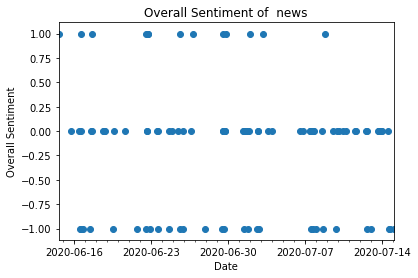

In [380]:
plotRes(df1)

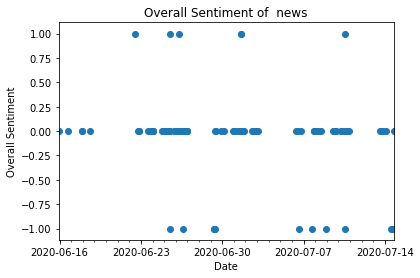

In [381]:
plotRes(df2)

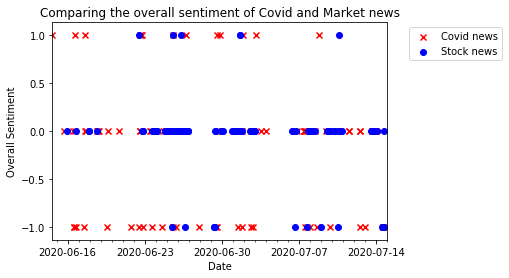

In [382]:
plotCompare(df1, df2)